In [1]:
# GTM Package including GTM and the plot functions
from gtm import *

import os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from demos.load_magic_data_helpers import *
from demos.dataset_helpers import Generic_Dataset

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# got up one directory as new working directory so that loading data works
# only run this once
os.chdir(os.path.dirname(os.getcwd()))

In [3]:
print(os.getcwd())

/Users/matthiasherp/Desktop/phd_github_repositories/gtm


#### Load Data

In [4]:
group = "h"

y_train_group_h, y_validate_group_h, y_test_group_h = load_magic_data(group=group,
                                                            train_portion=2/3,
                                                            data_dims=10,
                                                            poly_span_abs=12,
                                                            cross_validation_folds=5,
                                                            validation_fold_index=4,
                                                            split_random_state=25)
                

In [5]:
group = "g"

y_train_group_g, y_validate_group_g, y_test_group_g = load_magic_data(group=group,
                                                            train_portion=2/3,
                                                            data_dims=10,
                                                            poly_span_abs=12,
                                                            cross_validation_folds=5,
                                                            validation_fold_index=4,
                                                            split_random_state=25)
                

## Classification of Test Set

In [29]:
def magic_classification_report(loaded_model_g,
                                   loaded_model_h,
                                   data_g_test_normed,
                                   data_h_test_normed,
                                   data_h,
                                   data_g,
                                phi_g=False,
                                phi_h=False,
                                return_auc=False):

    data_g_test_normed = torch.tensor(data_g_test_normed)
    data_h_test_normed = torch.tensor(data_h_test_normed)

    fh_g = torch.exp(loaded_model_h.log_likelihood(data_g_test_normed)).detach()
    fh_h = torch.exp(loaded_model_h.log_likelihood(data_h_test_normed)).detach()
    fg_g = torch.exp(loaded_model_g.log_likelihood(data_g_test_normed)).detach()
    fg_h = torch.exp(loaded_model_g.log_likelihood(data_h_test_normed)).detach()

    likelihood_predictions = [fh_g, fh_h, fg_g, fg_h]
    names = ["fh_g", "fh_h", "fg_g", "fg_h"]

    for i in range(4):
        likelihood = likelihood_predictions[i]
        name = names[i]
        if likelihood.isnan().any():
            nan_index = (likelihood.isnan() == True).nonzero(as_tuple=True)
            print(name,"is NAN at:", nan_index)
            print("the observation is:", data_g_test_normed[nan_index])

        if likelihood.isinf().any():
            nan_index = (likelihood.isnan() == True).nonzero(as_tuple=True)
            print(name,"is INF at:", nan_index)
            print("the observation is:", data_g_test_normed[nan_index])

    if phi_g == False:
        phi_g = data_g.shape[0] / (data_h.shape[0] + data_g.shape[0])
        phi_h = 1 - phi_g

    bayes_prediction_g_g = phi_g * fg_g / (phi_g * fg_g + phi_h * fh_g)
    bayes_prediction_h_h = phi_h * fh_h / (phi_g * fg_h + phi_h * fh_h)

    if bayes_prediction_g_g.isnan().any():
        nan_index = (bayes_prediction_g_g.isnan() == True).nonzero(as_tuple=True)
        print("bayes_prediction_g_g is NAN at:", nan_index)
        bayes_prediction_g_g[bayes_prediction_g_g.isnan() == True] = phi_g
        print("Nan are replaced with prior probability phi_g", phi_g)

    if bayes_prediction_h_h.isnan().any():
        nan_index = (bayes_prediction_h_h.isnan() == True).nonzero(as_tuple=True)
        print("bayes_prediction_h_h is NAN at:", nan_index)
        bayes_prediction_h_h[bayes_prediction_h_h.isnan() == True] = phi_h
        print("Nan are replaced with prior probability phi_h", phi_h)

    # G=1, H=0
    y = np.concatenate((np.array([1.] * data_g_test_normed.size(0)), np.array([0.] * data_h_test_normed.size(0))),axis=0)
    y_pred_proba = np.concatenate((np.array(bayes_prediction_g_g), np.array(1 - bayes_prediction_h_h)), axis=0)

    fpr, tpr, _ = metrics.roc_curve(y, y_pred_proba)

    table_roc_curve = pd.DataFrame({"fpr": fpr, "tpr": tpr})
    
    if return_auc==True:
        from sklearn.metrics import roc_auc_score
        # Compute AUC-ROC
        auc_roc = roc_auc_score(y, y_pred_proba)
        return auc_roc
        
    return table_roc_curve



In [8]:
res_table = pd.DataFrame()
fpr_list = [0.01,0.02,0.05,0.1,0.2]
res_table["FPR"] = fpr_list

for num_decorr_layers in [3,4,5,6,7,8,9]:

    group = "h"
    loaded_model_h = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
    loaded_model_h.device = 'cpu'

    group = "g"
    loaded_model_g = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
    loaded_model_g.device = 'cpu'

    
    
    table_roc_curve = magic_classification_report(loaded_model_g,
                                                  loaded_model_h,
                                                  y_test_group_g,
                                                  y_test_group_h,
                                                  y_train_group_h,
                                                  y_train_group_g,
                                                  phi_g=0.5,
                                                  phi_h=0.5)
    model_tpr = []
    for fpr_quantile in [0.01,0.02,0.05,0.1,0.2]:
        model_tpr.append([
            np.round(table_roc_curve.loc[table_roc_curve.fpr <= fpr_quantile].tail(1)["tpr"].item(),3)
        ])
    res_table["GCTM_"+str(num_decorr_layers)] = np.stack(model_tpr)
    
res_table["Vine-Copula"] = [0.335,0.428,0.652,0.780,0.918]
res_table["MV-Kernel-DE"] = [0.335,0.408,0.567,0.730,0.868]

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_90492/2179354463.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_h = torch.load(os.path.join("dem

In [9]:
res_table

,FPR,GCTM_3,GCTM_4,GCTM_5,GCTM_6,GCTM_7,GCTM_8,GCTM_9,Vine-Copula,MV-Kernel-DE
0,0.01,0.342,0.319,0.312,0.317,0.310,0.309,0.292,0.335,0.335
1,0.02,0.453,0.397,0.455,0.412,0.414,0.442,0.448,0.428,0.408
2,0.05,0.639,0.637,0.634,0.645,0.650,0.655,0.650,0.652,0.567
3,0.10,0.796,0.812,0.818,0.816,0.816,0.805,0.810,0.780,0.730
4,0.20,0.916,0.920,0.923,0.924,0.922,0.926,0.922,0.918,0.868


(-0.05, 1.0)

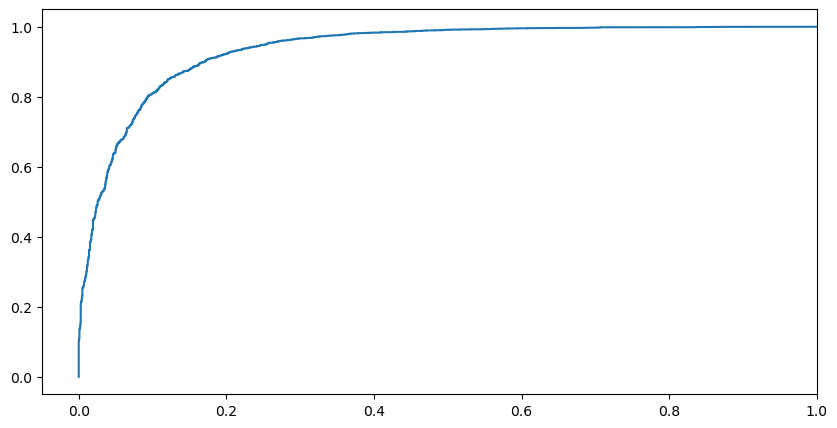

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(table_roc_curve["fpr"],table_roc_curve["tpr"])
plt.xlim(-0.05,1)

In [12]:
val_ll_h = []
val_ll_g = []

for num_decorr_layers in [3,4,5,6,7,8,9]:

    group = "h"
    loaded_model_h = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
    loaded_model_h.device = 'cpu'

    group = "g"
    loaded_model_g = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
    loaded_model_g.device = 'cpu'
    
    val_ll_h.append(loaded_model_h.log_likelihood(torch.FloatTensor(y_validate_group_h)).mean().detach().item())
    val_ll_g.append(loaded_model_g.log_likelihood(torch.FloatTensor(y_validate_group_g)).mean().detach().item())

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_90492/2240154346.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_h = torch.load(os.path.join("dem

In [18]:
num_decorr_layers_val_ll_table = pd.DataFrame()
num_decorr_layers = [3,4,5,6,7,8,9]
num_decorr_layers_val_ll_table["num_decorr_layers"] = num_decorr_layers
num_decorr_layers_val_ll_table["val_ll_h"] = val_ll_h
num_decorr_layers_val_ll_table["val_ll_g"] = val_ll_g

num_decorr_layers_val_ll_table.T

,0,1,2,3,4,5,6
num_decorr_layers,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
val_ll_h,-19.638666,-19.405394,-19.304016,-19.259886,-19.242109,-19.181589,-19.334702
val_ll_g,-14.064831,-13.787168,-13.596757,-13.549251,-13.639494,-13.647285,-13.608781


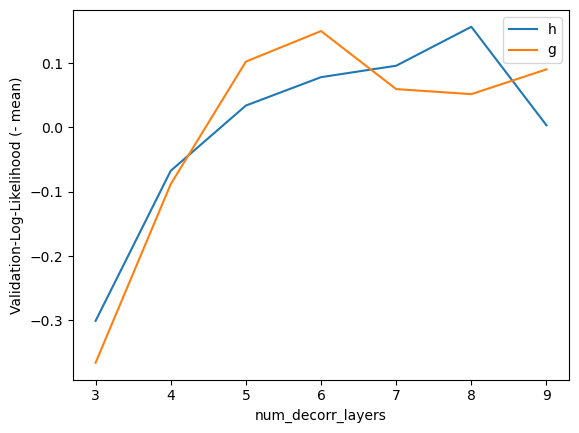

In [19]:
plt.plot(num_decorr_layers_val_ll_table["num_decorr_layers"],num_decorr_layers_val_ll_table["val_ll_h"]-num_decorr_layers_val_ll_table["val_ll_h"].mean(),label="h")
plt.plot(num_decorr_layers_val_ll_table["num_decorr_layers"],num_decorr_layers_val_ll_table["val_ll_g"]-num_decorr_layers_val_ll_table["val_ll_g"].mean(),label="g")
plt.xlabel('num_decorr_layers')
plt.ylabel('Validation-Log-Likelihood (- mean)')
plt.legend()
plt.show()

In [21]:
num_decorr_layers = num_decorr_layers_val_ll_table["num_decorr_layers"][num_decorr_layers_val_ll_table["val_ll_h"] == num_decorr_layers_val_ll_table["val_ll_h"].max()].item()
print("num_decorr_layers for h:",num_decorr_layers)
group = "h"
loaded_model_h = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
loaded_model_h.device = 'cpu'

num_decorr_layers = num_decorr_layers_val_ll_table["num_decorr_layers"][num_decorr_layers_val_ll_table["val_ll_g"] == num_decorr_layers_val_ll_table["val_ll_g"].max()].item()
print("num_decorr_layers for g:",num_decorr_layers)
group = "g"
loaded_model_g = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
loaded_model_g.device = 'cpu'

table_roc_curve = magic_classification_report(loaded_model_g,
                                              loaded_model_h,
                                              y_test_group_g,
                                              y_test_group_h,
                                              y_train_group_h,
                                              y_train_group_g,
                                              phi_g=0.5,
                                              phi_h=0.5)


model_tpr = []
for fpr_quantile in [0.01,0.02,0.05,0.1,0.2]:
    model_tpr.append([
        np.round(table_roc_curve.loc[table_roc_curve.fpr <= fpr_quantile].tail(1)["tpr"].item(),3)
    ])
res_table["GCTM_"+"opt"] = np.stack(model_tpr)

num_decorr_layers for h: 8
num_decorr_layers for g: 6


/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_90492/1723581073.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_h = torch.load(os.path.join("dem

In [22]:
res_table.T

,0,1,2,3,4
FPR,0.010,0.020,0.050,0.100,0.200
GCTM_3,0.342,0.453,0.639,0.796,0.916
GCTM_4,0.319,0.397,0.637,0.812,0.920
GCTM_5,0.312,0.455,0.634,0.818,0.923
GCTM_6,0.317,0.412,0.645,0.816,0.924
GCTM_7,0.310,0.414,0.650,0.816,0.922
GCTM_8,0.309,0.442,0.655,0.805,0.926
GCTM_9,0.292,0.448,0.650,0.810,0.922
Vine-Copula,0.335,0.428,0.652,0.780,0.918
MV-Kernel-DE,0.335,0.408,0.567,0.730,0.868


#### What depths would we chose based on combined AUC Classification Power on the Validation Set?

In [33]:
#auc_table = pd.DataFrame()
#fpr_list = [0.01,0.02,0.05,0.1,0.2]
#res_table["FPR"] = fpr_list

auc_list = []
num_decorr_layers1_list = []
num_decorr_layers2_list = []
for num_decorr_layers1 in [3,4,5,6,7,8,9]:
    for num_decorr_layers2 in [3,4,5,6,7,8,9]:


        group = "h"
        loaded_model_h = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers1}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
        loaded_model_h.device = 'cpu'

        group = "g"
        loaded_model_g = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers2}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
        loaded_model_g.device = 'cpu'

        auc = magic_classification_report(loaded_model_g,
                                                    loaded_model_h,
                                                    y_validate_group_g, #need to use validate data here
                                                    y_validate_group_h, #need to use validate data here
                                                    y_train_group_h,
                                                    y_train_group_g,
                                                    phi_g=0.5,
                                                    phi_h=0.5,
                                                    return_auc=True)
        auc_list.append(auc)
        num_decorr_layers1_list.append(num_decorr_layers1)
        num_decorr_layers2_list.append(num_decorr_layers2)

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_90492/4218609374.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_h = torch.load(os.path.join("de

In [34]:
auc_table = pd.DataFrame()
auc_table["num_decorr_layers1"] = num_decorr_layers1_list
auc_table["num_decorr_layers2"] = num_decorr_layers2_list
auc_table["auc"] = auc_list

auc_table.T

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
num_decorr_layers1,3.000000,3.00000,3.000000,3.000000,3.00000,3.000000,3.00000,4.000000,4.000000,4.000000,...,8.000000,8.000000,8.000000,9.000000,9.00000,9.000000,9.000000,9.000000,9.00000,9.000000
num_decorr_layers2,3.000000,4.00000,5.000000,6.000000,7.00000,8.000000,9.00000,3.000000,4.000000,5.000000,...,7.000000,8.000000,9.000000,3.000000,4.00000,5.000000,6.000000,7.000000,8.00000,9.000000
auc,0.931831,0.92975,0.931609,0.928877,0.93102,0.931033,0.92931,0.930022,0.928881,0.930576,...,0.930883,0.931565,0.929735,0.928824,0.92912,0.930845,0.928886,0.930394,0.93126,0.928942


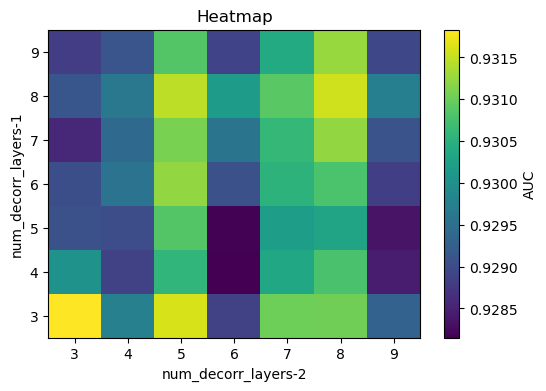

In [35]:
# Pivot the DataFrame to create a matrix for the heatmap
heatmap_data = auc_table.pivot(index='num_decorr_layers1', columns='num_decorr_layers2', values='auc')

# Plotting the heatmap
plt.figure(figsize=(6, 4))
plt.imshow(heatmap_data, cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(label='AUC')
plt.title('Heatmap')
plt.xlabel('num_decorr_layers-2')
plt.ylabel('num_decorr_layers-1')
plt.xticks(ticks=np.arange(len(heatmap_data.columns)), labels=heatmap_data.columns)
plt.yticks(ticks=np.arange(len(heatmap_data.index)), labels=heatmap_data.index)
plt.show()

In [36]:
num_decorr_layers = auc_table["num_decorr_layers1"][auc_table["auc"] == auc_table["auc"].max()].item()
print("num_decorr_layers for h:",num_decorr_layers)
group = "h"
loaded_model_h = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
loaded_model_h.device = 'cpu'

num_decorr_layers = auc_table["num_decorr_layers2"][auc_table["auc"] == auc_table["auc"].max()].item()
print("num_decorr_layers for g:",num_decorr_layers)
group = "g"
loaded_model_g = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
loaded_model_g.device = 'cpu'

table_roc_curve = magic_classification_report(loaded_model_g,
                                              loaded_model_h,
                                              y_test_group_g,
                                              y_test_group_h,
                                              y_train_group_h,
                                              y_train_group_g,
                                              phi_g=0.5,
                                              phi_h=0.5)


model_tpr = []
for fpr_quantile in [0.01,0.02,0.05,0.1,0.2]:
    model_tpr.append([
        np.round(table_roc_curve.loc[table_roc_curve.fpr <= fpr_quantile].tail(1)["tpr"].item(),3)
    ])
res_table["GCTM_"+"opt_auc"] = np.stack(model_tpr)

num_decorr_layers for h: 3
num_decorr_layers for g: 3


/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_90492/4282569500.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_h = torch.load(os.path.join("dem

In [37]:
res_table.T

,0,1,2,3,4
FPR,0.010,0.020,0.050,0.100,0.200
GCTM_3,0.342,0.453,0.639,0.796,0.916
GCTM_4,0.319,0.397,0.637,0.812,0.920
GCTM_5,0.312,0.455,0.634,0.818,0.923
GCTM_6,0.317,0.412,0.645,0.816,0.924
GCTM_7,0.310,0.414,0.650,0.816,0.922
GCTM_8,0.309,0.442,0.655,0.805,0.926
GCTM_9,0.292,0.448,0.650,0.810,0.922
Vine-Copula,0.335,0.428,0.652,0.780,0.918
MV-Kernel-DE,0.335,0.408,0.567,0.730,0.868
